In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os

In [26]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True

cuda:0


In [3]:
runs_list = next(os.walk('./Data/Images'))[1]

In [4]:
path = "./Data/Labels.csv"
header = ['Run','AD']
Labelsdf = pd.read_csv(path, names=header, usecols=[1,2], skiprows=1, index_col=False)

In [5]:
labels_dict = dict(zip(Labelsdf.Run, Labelsdf.AD))

In [6]:
# BASELINE RGB
img_dir = "./Data/Images"
low_bound = 100
high_bound = 200
img_scale = 1
depth_scale = 33
#list of tuples (image data, AD)
all_data = []
for run in runs_list:
    run_dir = os.path.join(img_dir, run)
    run_imgs = []
    for filename in os.listdir(run_dir):
        img_num = int(filename[-7:-4])
        if (100 <= img_num < 199):
            img_slice = cv2.imread(os.path.join(run_dir, filename), cv2.IMREAD_GRAYSCALE)
            #print(img_slice)
            #img_slice = cv2.resize(img_slice, (0,0), fx=1/img_scale, fy=1/img_scale, interpolation=cv2.INTER_AREA)
            img_slice = img_slice[40:216,:]
            run_imgs.append(img_slice)

    temp_arr = np.array(run_imgs)
    
    if temp_arr.size == 0 or not temp_arr.shape[1] == 176 or not temp_arr.shape[2] == 176:
        print(run)
        print(temp_arr.shape)
        continue
    
    final_slices = []
    #print(temp_arr.shape[2])
    
    for y in range(temp_arr.shape[2]):
        xz_pane = temp_arr[:, :, y]
        scaled_xz = cv2.resize(xz_pane, (0, 0), fy=1/depth_scale, fx=1, interpolation=cv2.INTER_AREA)
        final_slices.append(scaled_xz)
    
    if not len(final_slices[0]) == 3:
        continue
    
    final_array = torch.from_numpy(np.dstack(final_slices)).float()
    #print(final_array.shape)
    run_tuple = (final_array, labels_dict[run])
    all_data.append(run_tuple)
    
print(len(all_data), len(all_data[0]))
    

sub-OAS30059_ses-d0230_run-01
(29, 176, 256)
sub-OAS30059_ses-d0230_run-02
(29, 176, 256)
sub-OAS30059_ses-d0230_run-03
(29, 176, 256)
sub-OAS30059_ses-d0230_run-04
(29, 176, 256)
sub-OAS30059_ses-d1188
(99, 176, 160)
sub-OAS30109_ses-d0270
(99, 176, 160)
sub-OAS30119_ses-d1209_run-01
(29, 176, 256)
sub-OAS30119_ses-d1209_run-02
(29, 176, 256)
sub-OAS30119_ses-d1209_run-03
(29, 176, 256)
sub-OAS30249_ses-d0091_run-01
(29, 176, 256)
sub-OAS30249_ses-d0091_run-02
(29, 176, 256)
sub-OAS30249_ses-d0091_run-03
(29, 176, 256)
sub-OAS30249_ses-d0749
(99, 176, 160)
sub-OAS30259_ses-d0000_run-01
(29, 176, 256)
sub-OAS30259_ses-d0000_run-02
(29, 176, 256)
sub-OAS30259_ses-d0000_run-03
(29, 176, 256)
sub-OAS30259_ses-d0679_run-01
(29, 176, 256)
sub-OAS30259_ses-d0679_run-02
(29, 176, 256)
sub-OAS30259_ses-d0679_run-03
(29, 176, 256)
sub-OAS30369_ses-d2819_run-01
(29, 176, 256)
sub-OAS30369_ses-d2819_run-02
(29, 176, 256)
sub-OAS30369_ses-d2819_run-03
(29, 176, 256)
sub-OAS30379_ses-d1169_run-01
(

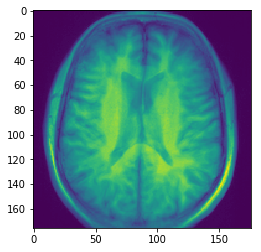

In [10]:
plt.imshow(all_data[0][0][1])

In [11]:
from torch.utils.data import Dataset, DataLoader

class T1Dataset(Dataset):
    def __init__(self, data, transform=None):
        # list of tuples (3d image arrays, AD label)
        self.data = data
        # labels.csv
        #self.target = torch.from_numpy(target).long()
        #self.transform = transforms.Compose([transforms.ToTensor()])
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        #scan = torch.from_numpy(self.data[index][0]).float()
        scan = self.data[index][0]
        y = self.data[index][1]
        return scan, y

In [12]:
scan_dataset = T1Dataset(all_data, None)

In [27]:
def train(model, dataset, num_epochs=10, batch_size=32, learning_rate=1e-4):
    criterion = nn.BCEWithLogitsLoss()
    # use Adam for CNN
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epochs, train_losses, val_losses, train_acc, val_acc = [], [], [], [], []
    
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    
    loss = 0
    
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()

        epochs.append(epoch)
        train_losses.append(loss)
        
        print(f"Epoch: {epoch} Training Loss: {train_losses[-1]}")
    
    plt.title("Training Curve")
    plt.plot(epochs, train_losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    
    print("Final Training Loss: {}".format(train_losses[-1]))

In [29]:
import torchvision.models

alexnet = torchvision.models.alexnet(pretrained=True)
alexnet.cuda()

dataset_list = list(scan_dataset)

imgs, labels = next(iter(torch.utils.data.DataLoader(dataset_list, batch_size=len(dataset_list), shuffle=True)))
imgs = imgs.float()
imgs = imgs.to(device)
features = alexnet.features(imgs)

In [30]:
features_list = []
for i in range(features.shape[0]):
    features_list.append((features[i], labels[i]))

In [31]:
print(features_list[0][0].shape)

torch.Size([256, 4, 4])


In [32]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.name = "CNN2"
        # 256x6x6
        self.fc1 = nn.Linear(256*4*4, 1024)
        nn.init.xavier_uniform(self.fc1.weight)
        #self.fc1 = nn.Linear(3*224*224, 512)
        self.fc2 = nn.Linear(1024, 512)
        nn.init.xavier_uniform(self.fc2.weight)
        self.fc3 = nn.Linear(512, 64)
        nn.init.xavier_uniform(self.fc3.weight)
        self.fc4 = nn.Linear(64, 1)
        nn.init.xavier_uniform(self.fc4.weight)
        #self.softmax = nn.Softmax()

    def forward(self, x):
        x = x.view(-1, 256*4*4)
        #x = x.view(-1, 3*224*224)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = F.relu(self.fc3(x))
        #print(x.shape)
        x = self.fc4(x)
        #x = self.softmax(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


Epoch: 0 Training Loss: 21.774913787841797
Epoch: 1 Training Loss: 1.890620470046997
Epoch: 2 Training Loss: 1.0088483095169067
Epoch: 3 Training Loss: 1.3323124647140503
Epoch: 4 Training Loss: 0.21226608753204346
Epoch: 5 Training Loss: 0.22008007764816284
Epoch: 6 Training Loss: 0.001527016400359571
Epoch: 7 Training Loss: 0.0011692626867443323
Epoch: 8 Training Loss: 0.0063000754453241825
Epoch: 9 Training Loss: 0.0001467974652769044


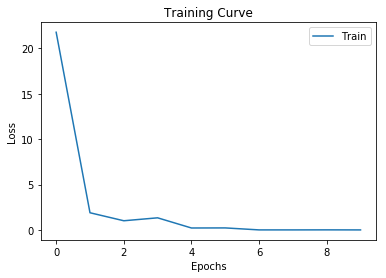

Final Training Loss: 0.0001467974652769044


In [33]:
alexnetCNN2 = CNN2()
alexnetCNN2.cuda()
train(alexnetCNN2, features_list, num_epochs=10, batch_size=32, learning_rate=1e-4)